## Importing necessary libraries 

In [58]:
import sklearn 
import numpy as np                  
import matplotlib.pyplot as plt   
import pandas as pd   
import os
import seaborn as sns

import torch
import torch.nn.functional as F #function such as activation,etc
from torch import nn 
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from functools import partial
from scipy import stats, interpolate

# %load_ext autoreload
# %autoreload 2

## Loading the dataset

In [59]:
data = pd.read_csv('https://raw.githubusercontent.com/dwipddalal/Epistemic-and-Aleatoric-Uncertainty-with-pytorch/main/credit_card_Dataset.csv')
data.head()

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,CST_128288,Rie,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,CST_151355,McCool,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0


### In this case we shall be working on find the relationship between credit card limit and the net yearly imcome of a person. Also we shall calculate the errors in the prediction of the model

In [60]:
X = data['net_yearly_income']
y = data['credit_limit']

In [61]:
from sklearn.model_selection import train_test_split
x, x_test, y, y_test = train_test_split(X[:18000], y[:18000], test_size=0.2, random_state=42)

In [62]:
x = x.values.reshape(-1,1)
x_test = x_test.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)

In [63]:
x_test.shape

(3600, 1)

In [64]:
mmsx = MinMaxScaler().fit(x)
x, x_test = mmsx.transform(x), mmsx.transform(x_test)

mmsy = MinMaxScaler().fit(y)
y, y_test = mmsy.transform(y), mmsy.transform(y_test)

### Creating the Model architecture 

In [65]:
class HeteroscedasticDropoutNet(nn.Module):
    def __init__(self, params):
        super().__init__() # this calls the intialization of the nn module method.
        self.model_ = nn.Sequential(
            nn.Linear(params['input_size'], params['hidden_size']), # params hidden_Size gives number of hidden nodes to the network
            nn.Dropout(params['dropout_p']),
            nn.Linear(params['hidden_size'], params['hidden_size_2']), # params hidden_Size gives number of hidden nodes to the network
            nn.Dropout(params['dropout_p_2']),
            nn.Linear(params['hidden_size_2'], params['output_size'])
        )
        self.optim_ = torch.optim.Adam(
            self.model_.parameters(), 
            lr=params['lr']
        )
    
    def forward(self, X):
        X = X.view(X.size(0), -1) # converts [128,1] to [128]
        return self.model_(X)
        
    
    def mc_predict(self, X, samples=4000):
        X = X.view(X.size(0), -1)
        with torch.no_grad():
            self.model_.train()
            preds = torch.stack([self.model_(X) for _ in range(samples)], dim=-1) # runs the model for 4000 times and stack the predicted output
        return preds


In [67]:
params = {
    'input_size': 1,
    'output_size': 1,
    'hidden_size': 156,
    'hidden_size_2': 64,
    'dropout_p': 0.4,
    'dropout_p_2': 0.2,
    'batch_size': 64,
    'epochs': 230,
    'lr': 1e-4,
}
model = HeteroscedasticDropoutNet(params)

In [68]:
x_train, y_train = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32) # have to convert the dataset to tensor before passing it in the torch 
x_val, y_val = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, params['batch_size'], shuffle=True)

### Defining the Loss Function

In [69]:
def gaussian_nll_loss(output, target):
    mu, sigma = output[:, :1], torch.exp(output[:, 0])
    dist = torch.distributions.Normal(mu, sigma)
    # print(target)
    loss = -dist.log_prob(target)
    # print(loss)
    return loss.sum()
criterion = gaussian_nll_loss

### Training

In [70]:
for epoch in range(params['epochs']):
    for x_batch, y_batch in train_dl:
        model.train()
        output = model(x_batch)
        # y_batch = y_batch.view(y_batch.shape[0], 1) 
        loss = criterion(output, y_batch)

        loss.backward()
        model.optim_.step()
        model.optim_.zero_grad()
    
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            output_train = model(x_train)
            mean_train = mean_absolute_error(y_train, output_train[:, :1])
            # y_train = y_train.view(y_train.shape[0],1)
            train_loss = criterion(output_train, y_train)
            output_val = model(x_val)
            mean_val = mean_absolute_error(y_val, output_val[:, :1])
            # y_val = y_val.view(y_val.shape[0],1)
            val_loss = criterion(output_val, y_val)
    
        print(f"Epoch: {epoch} \t Train loss:{train_loss:.5f} \t Val loss: {val_loss:.5f} \t MAE train: {mean_train:.5f} \t MAE val: {mean_val:.5f}")

Epoch: 0 	 Train loss:153501136.00000 	 Val loss: 9589511.00000 	 MAE train: 0.37543 	 MAE val: 0.37523
Epoch: 10 	 Train loss:153310768.00000 	 Val loss: 9578852.00000 	 MAE train: 0.38273 	 MAE val: 0.38252
Epoch: 20 	 Train loss:153310224.00000 	 Val loss: 9578868.00000 	 MAE train: 0.38010 	 MAE val: 0.37989
Epoch: 30 	 Train loss:153316544.00000 	 Val loss: 9579347.00000 	 MAE train: 0.37713 	 MAE val: 0.37692
Epoch: 40 	 Train loss:153303344.00000 	 Val loss: 9578494.00000 	 MAE train: 0.38312 	 MAE val: 0.38291
Epoch: 50 	 Train loss:153310336.00000 	 Val loss: 9579017.00000 	 MAE train: 0.37763 	 MAE val: 0.37742
Epoch: 60 	 Train loss:153321824.00000 	 Val loss: 9579759.00000 	 MAE train: 0.37557 	 MAE val: 0.37536
Epoch: 70 	 Train loss:153301024.00000 	 Val loss: 9578417.00000 	 MAE train: 0.38059 	 MAE val: 0.38038
Epoch: 80 	 Train loss:153302368.00000 	 Val loss: 9578472.00000 	 MAE train: 0.38374 	 MAE val: 0.38353
Epoch: 90 	 Train loss:153305680.00000 	 Val loss: 95787

In [71]:
x_train.shape

torch.Size([14400, 1])

In [72]:
preds_train = model.mc_predict(x_train, samples=4000).numpy()
preds_val = model.mc_predict(x_val, samples=4000).numpy()

In [73]:
si_train = x_train.argsort(dim=0).flatten()
train_x_, train_y_hat = x_train[si_train].numpy(), preds_train[si_train, :, :]
train_y_ = y_train[si_train].numpy()

si_val = x_val.argsort(dim=0).flatten()
val_x_, val_y_hat = x_val[si_val].numpy(), preds_val[si_val, :, :]
val_y_ = y_val[si_val].numpy()

In [74]:
print(train_y_hat.shape)

(14400, 1, 4000)


In [75]:
def postprocess_samples(samples):
    mus = np.mean(samples[:, 0, :], axis=-1)
    print(mus.shape)
    sigmas = np.mean(np.exp(samples[:, 0, :]), axis=-1)
    return mus, sigmas

In [76]:
pred_mu_train, pred_sigma_train = postprocess_samples(train_y_hat)
pred_mu_val, pred_sigma_val = postprocess_samples(val_y_hat)

(14400,)
(3600,)


In [77]:
# Dealing with the samples
sampled_mus = train_y_hat[:, 0, :]
mean_mus = sampled_mus.mean(axis=-1)
noises = np.exp(train_y_hat[:, 0, :])

# calculating different uncertainties
aleatoric = (noises**2).mean(axis=-1)**0.5
epistemic = (sampled_mus.std(axis=-1))

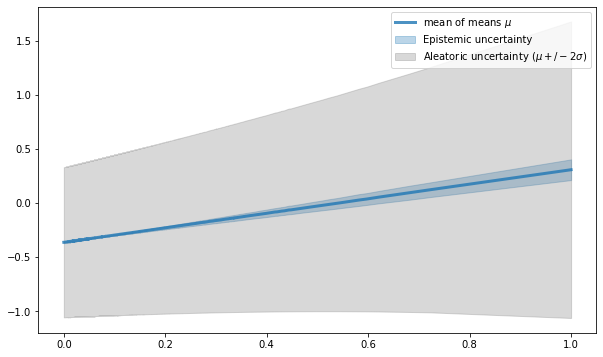

In [79]:
upper_ep = mean_mus + epistemic
lower_ep = mean_mus - epistemic
upper_total = mean_mus + aleatoric  # + 1 sigma
lower_total = mean_mus - aleatoric  # - 1 sigma

plt.figure(figsize=(10,6))
plt.plot(train_x_, mean_mus, lw=3, color='tab:blue', alpha=.8, label='mean of means $\mu$')
plt.fill_between(train_x_.flatten(), lower_ep, upper_ep, alpha=.3, color='tab:blue', label='Epistemic uncertainty')
plt.fill_between(train_x_.flatten(), lower_total, upper_total, alpha=.3, color='grey', label='Aleatoric uncertainty ($\mu +/- 2\sigma$)')
plt.legend();